In [4]:
!pip install pandas



     --------------------------------------- 10.0/10.0 MB 24.5 MB/s eta 0:00:00




     ------------------------------------- 502.3/502.3 kB 30.8 MB/s eta 0:00:00






In [6]:
!pip install imageio



     -------------------------------------- 312.7/312.7 kB 9.8 MB/s eta 0:00:00




     ---------------------------------------- 2.5/2.5 MB 13.4 MB/s eta 0:00:00




In [8]:
!pip install matplotlib



     ---------------------------------------- 7.2/7.2 MB 20.0 MB/s eta 0:00:00


  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)



     ---------------------------------------- 54.9/54.9 kB 2.8 MB/s eta 0:00:00





  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)







In [6]:
!pip install opencv-python



     --------------------------------------- 38.2/38.2 MB 25.2 MB/s eta 0:00:00





### Importing libraries

In [2]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

from pathlib import Path

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Preparing data

In [3]:
train_path = Path("/kaggle/input/car-object-detection/data/training_images")
test_path = Path("/kaggle/input/car-object-detection/data/testing_images")

In [4]:
train = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Some display functions

In [5]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    if norm:
        img *= 255. 
        img = img.astype(np.uint8)
        
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [6]:
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

In [7]:
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)

In [8]:
def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos+1)
        display_from_dataframe(df.loc[index, :])

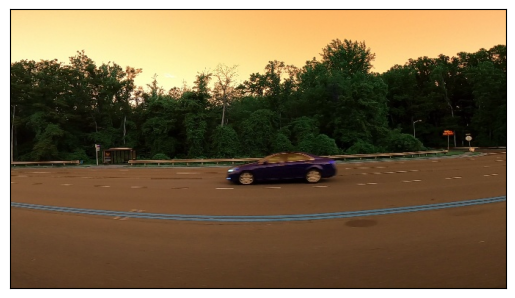

In [9]:
display_image_from_file('vid_4_860.jpg')

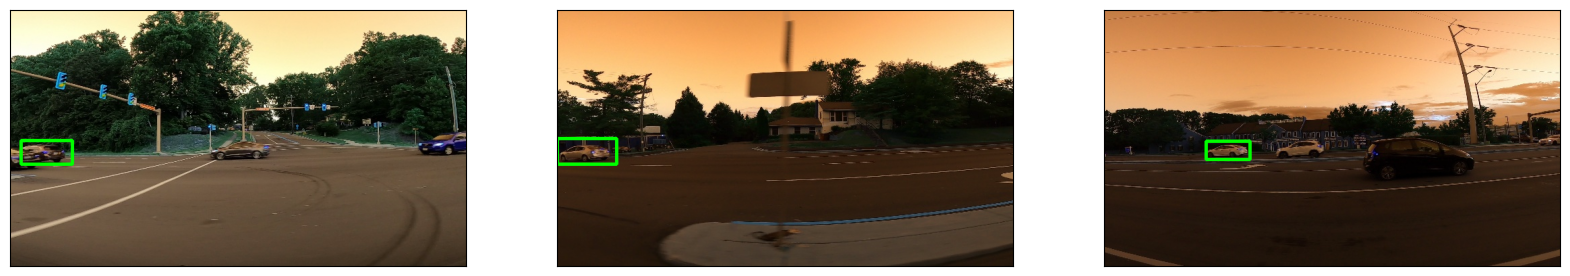

In [10]:
display_grid()

Clarification: green bounding boxes are the correct labels and red bounding boxes are predicted labels.

### Model training

In [11]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
            rand_index= np.random.randint(0, train.shape[0])
            row = df.loc[rand_index, :]
            images[i] = cv2.imread(str(train_path/row.image)) / 255
            bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
            
        yield {'image': images}, {'coords': bounding_box_coords}

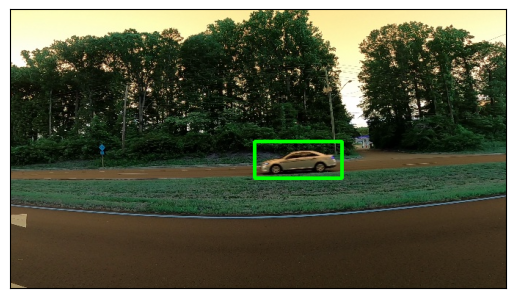

In [12]:
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

### Model building

In [13]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 380, 676, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 190, 338, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 190, 338, 16)     64    

In [14]:
model.compile(loss={'coords': 'mse'}, optimizer=tf.keras.optimizers.Adam(1e-3), metrics={'coords': 'accuracy'})

In [15]:
def test_model(model, datagen):
    example, label = next(datagen)
    
    X= example['image']
    y= label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)
    
def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1,3,i+1)
        test_model(model, datagen)
        
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

1/1 [==============================] - 0s 25ms/step


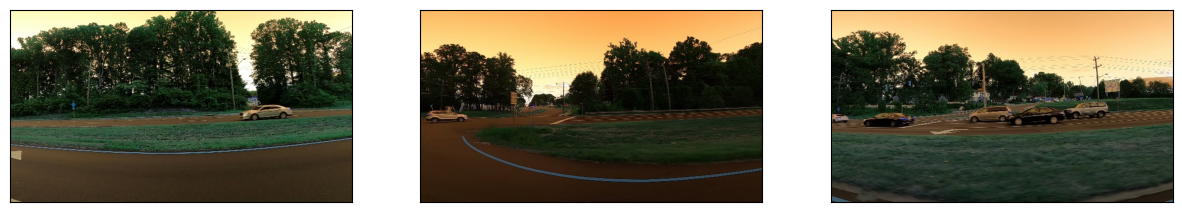

In [16]:
test(model)

Epoch 1/9
1/1 [==============================] - 0s 23ms/step


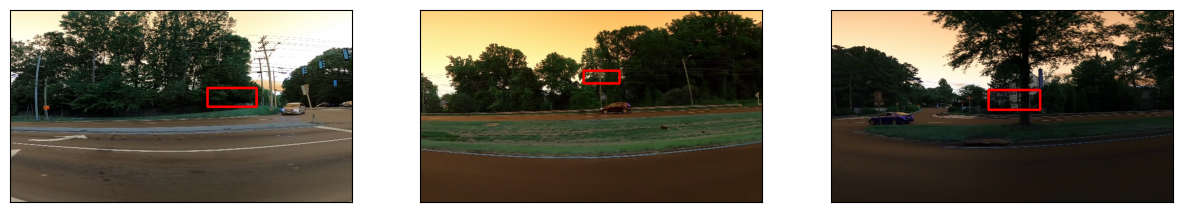

500/500 [==============================] - 166s 303ms/step - loss: 5113.1401 - accuracy: 0.8544
Epoch 2/9
1/1 [==============================] - 0s 45ms/step


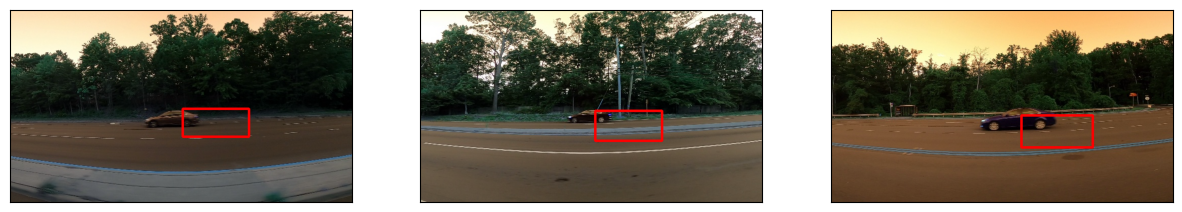

500/500 [==============================] - 148s 296ms/step - loss: 1259.1512 - accuracy: 0.9528
Epoch 3/9
1/1 [==============================] - 0s 24ms/step


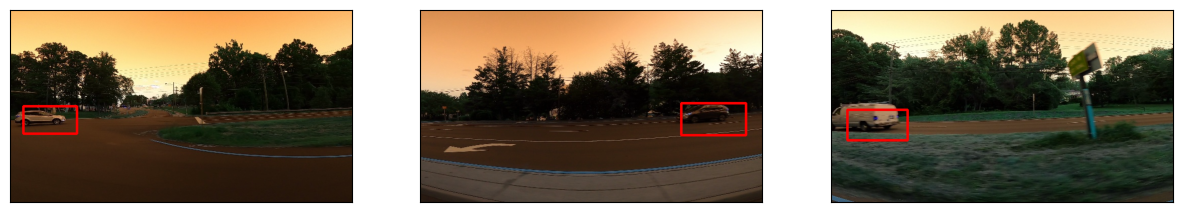

500/500 [==============================] - 148s 296ms/step - loss: 484.6519 - accuracy: 0.9715
Epoch 4/9
1/1 [==============================] - 0s 25ms/step


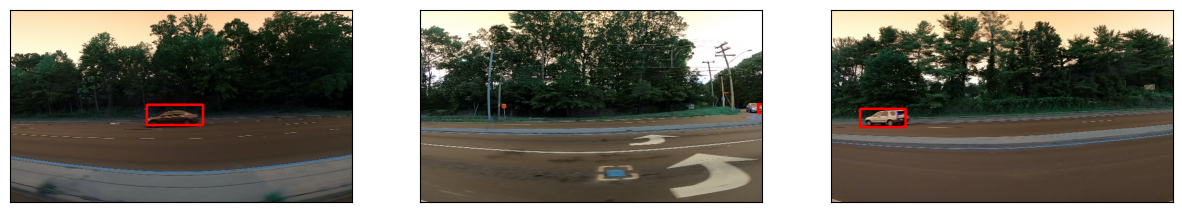

500/500 [==============================] - 149s 299ms/step - loss: 247.5091 - accuracy: 0.9799
Epoch 5/9
1/1 [==============================] - 0s 22ms/step


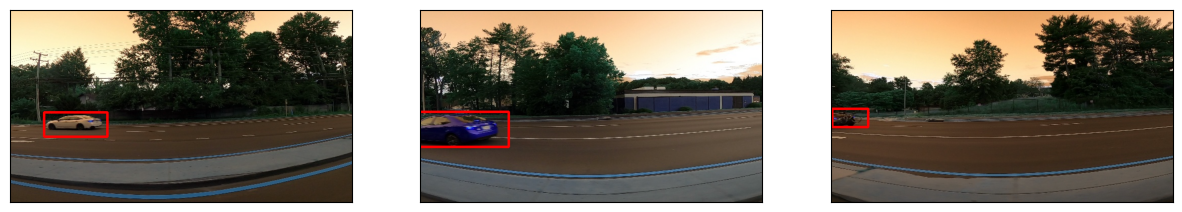

500/500 [==============================] - 147s 293ms/step - loss: 156.5251 - accuracy: 0.9858
Epoch 6/9
1/1 [==============================] - 0s 26ms/step


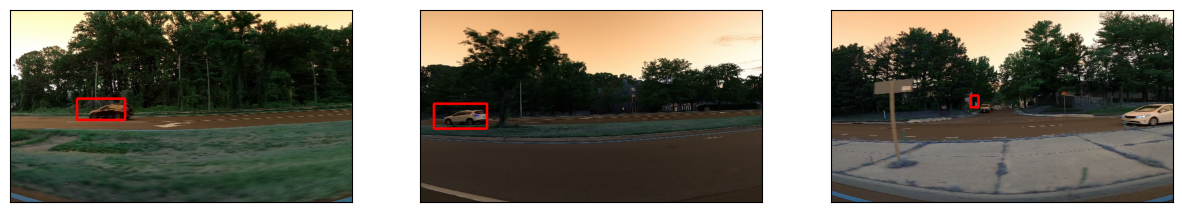

500/500 [==============================] - 147s 293ms/step - loss: 111.8395 - accuracy: 0.9906
Epoch 7/9
1/1 [==============================] - 0s 23ms/step


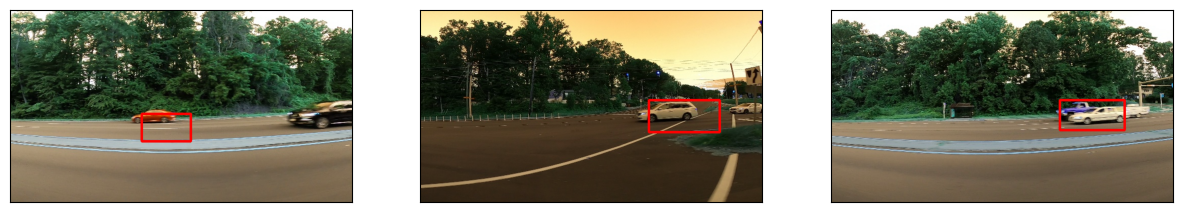

500/500 [==============================] - 146s 292ms/step - loss: 119.9935 - accuracy: 0.9874
Epoch 8/9
1/1 [==============================] - 0s 24ms/step


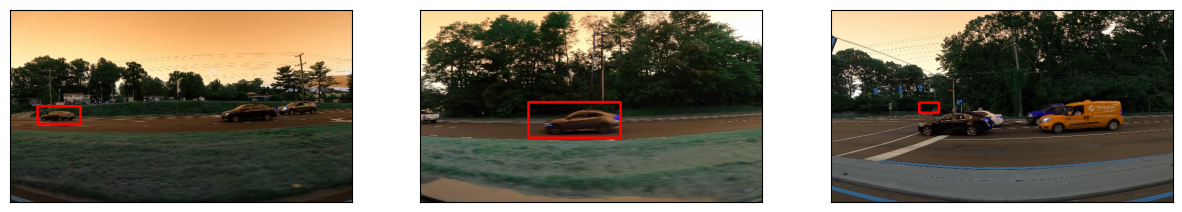

500/500 [==============================] - 147s 294ms/step - loss: 110.3337 - accuracy: 0.9891
Epoch 9/9
1/1 [==============================] - 0s 24ms/step


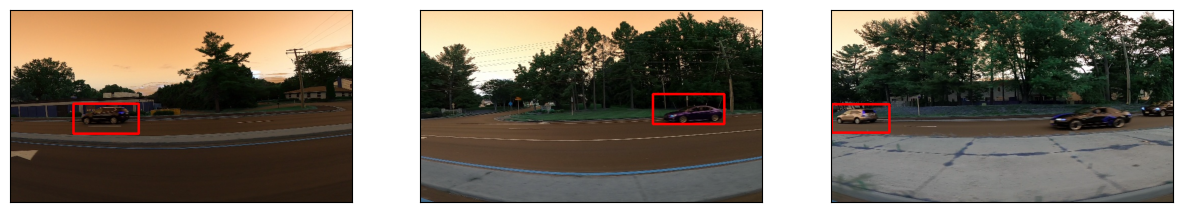

500/500 [==============================] - 147s 293ms/step - loss: 129.1473 - accuracy: 0.9909


In [17]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )